# Working Notebook
A notebook to work and test different ideas and thoughts in the building of forecast automation. 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import yaml
import os
import pyodbc
import glob
import copy
import traceback
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download some data
mgra_ds99 = pd.read_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\aggregated_data\mgra_DS99_ind_QA.csv')

In [3]:
ds99_41_diff = pd.read_csv(r'J:\DataScience\DataQuality\QAQC\forecast_automation\mgra_series_13_outputs_CSV_data\diff_files\mgra_diff_DS99_minus_DS41_QA.csv')

In [ ]:
# Localise with . files 
if os.getcwd().split('\\')[-1] == 'scripts':
    config_filename = '../config_files/ds_config.yml'
else:
    config_filename = './config_files/ds_config.yml'

In [19]:
with open('ds_config_2.yml', "r") as yml_file:
    config = yaml.safe_load(yml_file)

In [20]:
config.keys()

dict_keys(['35', 'DS39', 'DS41', 'DS38', 'DS42', 'DS99', 'dof'])

In [30]:
for file in config['35']['T_Drive_files'].values():
    print(file)

T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2016_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2018_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2020_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2023_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2025_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2026_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2029_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2030_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2032_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2035_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2040_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2045_01.csv
T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2050_01.csv


In [31]:
def t_drive_file_paths(dsid):
    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)
    
    return config[dsid]['T_Drive_files'].values()


In [32]:
t_drive_file_paths('35')

dict_values(['T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2016_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2018_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2020_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2023_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2025_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2026_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2029_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2030_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2032_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2035_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2040_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2045_01.csv', 'T:/socioec/Current_Projects/XPEF31/abm_csv/mgra13_based_input2050_01.csv']

In [38]:
def download_and_concat_Tdrive_files(dsid):
    file_paths = t_drive_file_paths(dsid)

    
    frames = [pd.read_csv(file) for file in file_paths]
    
    return pd.concat(frames)

In [48]:
'happy2050'[-4:]

'2050'

In [61]:
def download_and_concat_Tdrive_files(dsid):
    """Downloads all of the files from T drive for this particular dsid and adds the year"""
    
    with open('ds_config_2.yml', "r") as yml_file:
        config = yaml.safe_load(yml_file)

    concatonated_dfs = pd.DataFrame()

    for key, path in config[dsid]['T_Drive_files'].items():
        temp_df = pd.read_csv(path)
        temp_df['year'] = key[-4:]
        concatonated_dfs = pd.concat([concatonated_dfs, temp_df])
    
    return concatonated_dfs

In [62]:
all_35_df = download_and_concat_Tdrive_files('35')

In [65]:
all_35_df.groupby(['year', 'mgra']).sum()

taz   hs  hs_sf  hs_mf  hs_mh   hh  hh_sf  hh_mf  hh_mh  gq_civ  \
year mgra                                                                      
2016 1      3331   19     19      0      0   18     18      0      0       0   
     2      3331   35     35      0      0   34     34      0      0       0   
     3      3358   52     52      0      0   52     52      0      0       0   
     4      3358   30     30      0      0   30     30      0      0       0   
     5      3358   28     28      0      0   28     28      0      0       0   
...          ...  ...    ...    ...    ...  ...    ...    ...    ...     ...   
2050 22998  1290   92     92      0      0   87     87      0      0       0   
     22999  1290    0      0      0      0    0      0      0      0       0   
     23000  1290  131    131      0      0  126    126      0      0       0   
     23001  1254   85     85      0      0   82     82      0      0       0   
     23002  1254  120     20    100      0  109     17     92      0       0   

            ...  midpriceroom  upscaleroom  hotelroomtotal  luz_id  \
year mgra   ...                                                      
2016 1      ...             0            0               0      95   
     2      ...             0            0               0      95   
     3      ...             0            0               0      95   
     4      ...             0            0               0      95   
     5      ...             0            0               0      95   
...         ...           ...          ...             ...     ...   
2050 22998  ...             0            0               0      14   
     22999  ...             0            0               0      14   
     23000  ...             0            0               0      14   
     23001  ...             0            0               0      14   
     23002  ...             0            0               0      14   

            truckregiontype  district27  milestocoast      acres  \
year mgra                                                          
2016 1                    1          27        3.7997  16.615444   
     2                    1          27        3.9761  19.519185   
     3                    1          27        4.1939  27.845124   
     4                    1          27        4.2782   7.976178   
     5                    1          27        4.0062   7.072502   
...                     ...         ...           ...        ...   
2050 22998                1           1        2.6193  41.241522   
     22999                1           1        2.3703  35.842780   
     23000                1           1        2.1721  28.735275   
     23001                1           1        2.7063  41.006144   
     23002                1           1        2.4553  50.823736   

            effective_acres  land_acres  
year mgra                                
2016 1            12.961482   16.615444  
     2            19.519185   19.519185  
     3            26.867938   27.845124  
     4             7.976178    7.976178  
     5             7.063693    7.072502  
...                     ...         ...  
2050 22998        26.863578   41.241522  
     22999        30.635095   35.842780  
     23000        16.109816   28.735275  
     23001        28.126056   41.006144  
     23002        34.131049   50.823736  

[299026 rows x 103 columns]

In [78]:
'luz_id' in all_35_df.columns

True

In [79]:
'taz' in all_35_df.columns

True

In [81]:
level = 'taz'

In [87]:
def wanted_geography_cols(df, wanted_geo_level):
    """Returns a list of columns that do not include unwanted geography levels."""
    geography_levels = ['mgra', 'luz_id', 'taz'] # TODO: Add more to this list as I append more to the MGRA column 
    geography_levels.remove(wanted_geo_level)

    return [col for col in df.columns if col not in geography_levels]

In [ ]:
def region_rollup

In [ ]:
all_35_df

In [88]:
wanted_geography_cols(all_35_df, 'taz')

['taz',
 'hs',
 'hs_sf',
 'hs_mf',
 'hs_mh',
 'hh',
 'hh_sf',
 'hh_mf',
 'hh_mh',
 'gq_civ',
 'gq_mil',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'hhs',
 'pop',
 'hhp',
 'emp_ag',
 'emp_const_non_bldg_prod',
 'emp_const_non_bldg_office',
 'emp_utilities_prod',
 'emp_utilities_office',
 'emp_const_bldg_prod',
 'emp_const_bldg_office',
 'emp_mfg_prod',
 'emp_mfg_office',
 'emp_whsle_whs',
 'emp_trans',
 'emp_retail',
 'emp_prof_bus_svcs',
 'emp_prof_bus_svcs_bldg_maint',
 'emp_pvt_ed_k12',
 'emp_pvt_ed_post_k12_oth',
 'emp_health',
 'emp_personal_svcs_office',
 'emp_amusement',
 'emp_hotel',
 'emp_restaurant_bar',
 'emp_personal_svcs_retail',
 'emp_religious',
 'emp_pvt_hh',
 'emp_state_local_gov_ent',
 'emp_fed_non_mil',
 'emp_fed_mil',
 'emp_state_local_gov_blue',
 'emp_state_local_gov_white',
 'emp_public_ed',
 'emp_own_occ_dwell_mgmt',
 'emp_fed_gov_accts',
 'emp_st_lcl_gov_accts',
 'emp_cap_accts',
 'emp_total',
 'enrollgradekto8',
 'enrollgrade9to12',


In [89]:
geography_levels = ['mgra', 'luz_id', 'taz']
geography_levels.remove('pie')

ValueError: list.remove(x): x not in list

In [85]:
geography_levels = ['mgra', 'luz_id', 'taz']
geography_levels.remove(level)
print(geography_levels)

wanted_columns = [col for col in all_35_df.columns if col not in geography_levels]
wanted_columns

['mgra', 'luz_id']


['taz',
 'hs',
 'hs_sf',
 'hs_mf',
 'hs_mh',
 'hh',
 'hh_sf',
 'hh_mf',
 'hh_mh',
 'gq_civ',
 'gq_mil',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'hhs',
 'pop',
 'hhp',
 'emp_ag',
 'emp_const_non_bldg_prod',
 'emp_const_non_bldg_office',
 'emp_utilities_prod',
 'emp_utilities_office',
 'emp_const_bldg_prod',
 'emp_const_bldg_office',
 'emp_mfg_prod',
 'emp_mfg_office',
 'emp_whsle_whs',
 'emp_trans',
 'emp_retail',
 'emp_prof_bus_svcs',
 'emp_prof_bus_svcs_bldg_maint',
 'emp_pvt_ed_k12',
 'emp_pvt_ed_post_k12_oth',
 'emp_health',
 'emp_personal_svcs_office',
 'emp_amusement',
 'emp_hotel',
 'emp_restaurant_bar',
 'emp_personal_svcs_retail',
 'emp_religious',
 'emp_pvt_hh',
 'emp_state_local_gov_ent',
 'emp_fed_non_mil',
 'emp_fed_mil',
 'emp_state_local_gov_blue',
 'emp_state_local_gov_white',
 'emp_public_ed',
 'emp_own_occ_dwell_mgmt',
 'emp_fed_gov_accts',
 'emp_st_lcl_gov_accts',
 'emp_cap_accts',
 'emp_total',
 'enrollgradekto8',
 'enrollgrade9to12',


In [76]:
a = ['mgra', 'luz_id', 'taz']
a.remove(['bread', 'cheese'])

print(a)

ValueError: list.remove(x): x not in list

In [75]:
all_35_df[['mgra', 'luz_id', 'taz']]

,mgra,luz_id,taz
0,1,95,3331
1,2,95,3331
2,3,95,3358
3,4,95,3358
4,5,95,3358
...,...,...,...
22997,22998,14,1290
22998,22999,14,1290
22999,23000,14,1290
23000,23001,14,1254


In [54]:
concatonated_dfs = pd.DataFrame()

for key, path in config['35']['T_Drive_files'].items():
    temp_df = pd.read_csv(path)
    temp_df['year'] = key[-4:]
    concatonated_dfs = pd.concat([concatonated_dfs, temp_df])

In [55]:
concatonated_dfs

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,year
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444,2016
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185,2016
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124,2016
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178,2016
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,92,92,0,0,87,87,0,0,...,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522,2050
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780,2050
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275,2050
23000,23001,1254,85,85,0,0,82,82,0,0,...,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144,2050


In [49]:
[key[-4:] for key in config['35']['T_Drive_files'].keys()]

['2016',
 '2018',
 '2020',
 '2023',
 '2025',
 '2026',
 '2029',
 '2030',
 '2032',
 '2035',
 '2040',
 '2045',
 '2050']

In [41]:
frames = [pd.read_csv(file) for file in t_drive_file_paths('35')]

In [44]:
frames[2]

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,90,90,0,0,87,87,0,0,...,0,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275
23000,23001,1254,83,83,0,0,81,81,0,0,...,0,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144


In [39]:
all_35_data = download_and_concat_Tdrive_files('35')

13


In [37]:
all_35_data

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres
0,1,3331,19,19,0,0,18,18,0,0,...,0,0,0,95,1,27,3.7997,16.615444,12.961482,16.615444
1,2,3331,35,35,0,0,34,34,0,0,...,0,0,0,95,1,27,3.9761,19.519185,19.519185,19.519185
2,3,3358,52,52,0,0,52,52,0,0,...,0,0,0,95,1,27,4.1939,27.845124,26.867938,27.845124
3,4,3358,30,30,0,0,30,30,0,0,...,0,0,0,95,1,27,4.2782,7.976178,7.976178,7.976178
4,5,3358,28,28,0,0,28,28,0,0,...,0,0,0,95,1,27,4.0062,7.072502,7.063693,7.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,22998,1290,92,92,0,0,87,87,0,0,...,0,0,0,14,1,1,2.6193,41.241522,26.863578,41.241522
22998,22999,1290,0,0,0,0,0,0,0,0,...,0,0,0,14,1,1,2.3703,35.842780,30.635095,35.842780
22999,23000,1290,131,131,0,0,126,126,0,0,...,0,0,0,14,1,1,2.1721,28.735275,16.109816,28.735275
23000,23001,1254,85,85,0,0,82,82,0,0,...,0,0,0,14,1,1,2.7063,41.006144,28.126056,41.006144


In [15]:
config['DS35'].keys()

dict_keys(['T_Drive_files', 'Household_Files', 'Person_Files', 'forecast_ID'])

In [16]:
config['DS41'].keys()

dict_keys(['DS41_2016', 'DS41_2018', 'DS41_2020', 'DS41_2023', 'DS41_2025', 'DS41_2026', 'DS41_2029', 'DS41_2030', 'DS41_2032', 'DS41_2035', 'DS41_2040', 'DS41_2045', 'DS41_2050', 'forecast_ID'])

In [4]:
from data_qc_funcs import *

In [9]:
percentile_outlier_check(ds99_41_diff, column='hhp', lower_percentile=.1, upper_percentile=99.99, level='mgra')

hhp
year mgra       
2018 2498   -716
     2583   -675
     5873   2230
     16968  -584
     16973  -783
...          ...
2050 16973 -1717
     16976 -1450
     16978  -941
     17888  -950
     22500  -688

[330 rows x 1 columns]

In [5]:
ds99_41_diff

,mgra,year,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,...,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations
0,1,2016,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
1,1,2018,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
2,1,2020,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
3,1,2023,0,-1,-1,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
4,1,2025,0,0,0,0,0,1,1,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,23002,2032,0,0,0,0,0,-8,-1,-7,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299022,23002,2035,0,0,0,0,0,0,-1,1,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299023,23002,2040,0,0,0,0,0,-4,-2,-2,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
299024,23002,2045,0,0,0,0,0,-11,-4,-7,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0


In [6]:
mgra_ds99

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,year
0,1,3331,19,19,0,0,18,18,0,0,...,1,27,3.7997,16.615444,12.961482,16.615444,10,0,0,2016
1,2,3331,35,35,0,0,34,34,0,0,...,1,27,3.9761,19.519185,19.519185,19.519185,10,0,0,2016
2,3,3358,52,52,0,0,52,52,0,0,...,1,27,4.1939,27.845124,26.867938,27.845124,10,0,0,2016
3,4,3358,30,30,0,0,30,30,0,0,...,1,27,4.2782,7.976178,7.976178,7.976178,10,0,0,2016
4,5,3358,28,28,0,0,28,28,0,0,...,1,27,4.0062,7.072502,7.063693,7.072502,10,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299021,22998,1290,90,90,0,0,87,87,0,0,...,1,1,2.6193,41.241522,26.863578,41.241522,120,0,0,2050
299022,22999,1290,0,0,0,0,0,0,0,0,...,1,1,2.3703,35.842780,30.635095,35.842780,120,0,0,2050
299023,23000,1290,131,131,0,0,126,126,0,0,...,1,1,2.1721,28.735275,16.109816,28.735275,120,0,0,2050
299024,23001,1254,83,83,0,0,81,81,0,0,...,1,1,2.7063,41.006144,28.126056,41.006144,120,0,0,2050


data

In [16]:
import numpy as np

#make this example reproducible
np.random.seed(0)

#create array of 100 random integers distributed between 0 and 500
data = np.random.randint(0, 500, 100)

#find the 37th percentile of the array
np.percentile(data, 37)

173.26

#Find the quartiles (25th, 50th, and 75th percentiles) of the array
np.percentile(data, [25, 50, 75])

array([116.5, 243.5, 371.5])

In [24]:
np.percentile([-10,-5,8,12,34,56,23,13,45,32], 5)

-7.75

In [25]:
def percentile_outlier_check(df, column, lower_percentile, upper_percentile):
    lower_value = np.percentile(df[column], lower_percentile)
    upper_value = np.percentile(df[column], upper_percentile)

    return df[(df[column] < lower_value) | (df[column] > upper_value)]

In [28]:
percentile_outlier_check(mgra_ds99, column='pop', lower_percentile=1, upper_percentile=99)

,mgra,taz,hs,hs_sf,hs_mf,hs_mh,hh,hh_sf,hh_mf,hh_mh,...,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,year
923,924,3460,466,0,466,0,459,0,459,0,...,1,9,7.8885,29.567792,28.087264,29.567792,120,0,0,2016
1033,1034,3626,419,419,0,0,410,410,0,0,...,1,9,7.8338,73.917036,44.458479,73.917036,120,0,0,2016
1057,1058,3849,682,0,682,0,650,0,650,0,...,1,9,6.3352,37.719066,37.719066,37.719066,120,0,0,2016
1072,1073,3176,516,4,512,0,491,4,487,0,...,1,9,8.8151,14.500468,14.167150,14.500468,10,0,0,2016
1212,1213,3142,0,0,0,0,0,0,0,0,...,1,9,9.0774,12.375594,12.375594,12.375594,10,0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298603,22580,3751,519,519,0,0,516,516,0,0,...,1,26,1.9936,57.297810,57.297810,57.297810,10,0,0,2050
298705,22682,1877,473,0,473,0,472,0,472,0,...,1,2,4.3175,104.335839,104.335839,104.335839,120,0,0,2050
298731,22708,4392,1574,0,1574,0,810,0,810,0,...,1,10,0.0817,41.988054,27.933706,41.988054,120,0,0,2050
298863,22840,4395,0,0,0,0,0,0,0,0,...,1,10,2.4816,295.077406,153.956605,156.671125,10,0,0,2050


In [17]:
data

array([172,  47, 117, 192, 323, 251, 195, 359,   9, 211, 277, 242, 292,
        87,  70, 472,  88, 396, 314, 193, 486,  39,  87, 174,  88, 337,
       165,  25, 333,  72, 265, 404, 115, 464, 243, 197, 335, 431, 448,
       338,  99, 472, 177, 243, 285, 147, 147, 398, 423, 288, 449, 265,
       185, 127,  32,  31, 202, 244, 151, 163, 459, 370, 183,  28, 290,
       128, 128, 420,  53, 389,  38, 488, 244, 273, 335, 388, 105,  42,
       442,  31, 376, 257, 321, 487, 425,  57, 291, 358, 119, 267, 430,
        82,  91, 384, 398,  99,  53, 396, 121, 426])

(array([110., 307., 247., 168.,  84.,  37.,  28.,  10.,   3.,   3.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.59044299,  1.54462417,  2.49880535,  3.45298653,  4.40716771,
         5.36134889,  6.31553007,  7.26971125,  8.22389243,  9.17807361,
        10.13225479, 11.08643597, 12.04061715, 12.99479833, 13.94897951,
        14.90316069, 15.85734187, 16.81152305, 17.76570423, 18.71988542,
        19.6740666 ]),
 <BarContainer object of 20 artists>)

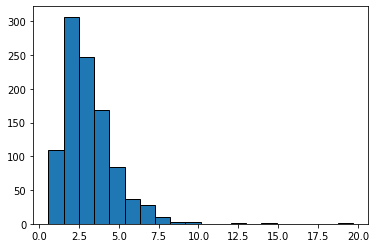

In [7]:
import math
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

#make this example reproducible
np.random.seed(1)

#generate dataset that contains 1000 log-normal distributed values
lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

#create histogram to visualize values in dataset
plt.hist(lognorm_dataset, edgecolor='black', bins=20)

(array([33.,  0.,  0., 12.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,
         1.,  2.,  2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  1.,  1.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  2.,
         0.,  0.,  1.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

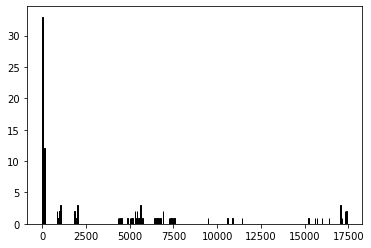

In [14]:
plt.hist(mgra_ds99[mgra_ds99['pop']>5000]['hhp'], edgecolor='black', bins=500)

In [9]:
mgra_ds99['pop']

0          41
1          81
2         111
3          73
4          63
         ... 
299021    196
299022      0
299023    307
299024    184
299025    262
Name: pop, Length: 299026, dtype: int64

Quantitative: 
- 